# KSA: Polar Observations and Modelling

# Week 6 - Gridded data

We've done an initial exploring of EN4.2.2., doing some basic plots to try to understand changes throughout time in `1_Introduction_to_EN422.ipynb`.

Now we will look at changes in a bit more robust way: by computing linear trends. We will use the `xarrayMannKendall` library, which provides a really easy way to compute linear trends and significance in 3D datasets.

There are various ways of computing linear trends, but some of them, like linear regressions, require your data to follow a certain distribution. The Mann Kendall test is non-parametric, meaning that it does not assume any distribution in the data. There are a few things to take into account - for example, our data should not have any serial correlation which means it shouldn't be correlated with itself at any lag. Imagine we had a timeseries of monthly temperatures. The seasonal cycle involves higher temperatures in summer and lower in winter which means your timeseries will be correlated with itself and the individual months are not independent from each other. 

Because we are working with annual averages, we don't have to do anything to our timeseries. Otherwise, we would have to filter out the seasonal cycle.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xarrayMannKendall as xrmk

In [2]:
EN422 = xr.open_dataset('/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class3/data/EN422_annual_averages_1970-2021.nc')
EN422['temperature'] = EN422['temperature'] - 273.15

Do you remember why we are substracting 273.15 from the temperature?

# Surface properties trends

Let's begin by looking at the trends in surface temperature and salinity:

In [3]:
surface_temp = EN422['temperature'].sel(depth = 0, method = 'nearest')
surface_salt = EN422['salinity'].sel(depth = 0, method = 'nearest')

Now we can use `xarrayMannKendall` to calculate linear trends. The function to do this accepts 3D datasets, assuming one of those dimensions represents time, and the other two are spatial dimensions. We need to specify in the function two things:
- The dimension along which we want to calculate the trends, which for us will be `time`
- In our dataset, how do we call the `time`, `x` and `y` dimensions, which in our case are called `time`, `lon` and `lat`

In [4]:
MK_class = xrmk.Mann_Kendall_test(surface_temp, 
                                  'time',
                                  coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
surface_temp_trends = MK_class.compute()

In [5]:
surface_temp_trends

<xarray.Dataset> Size: 566kB
Dimensions:    (y: 49, x: 360)
Coordinates:
  * x          (x) float32 1kB -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * y          (y) float32 196B -83.0 -82.0 -81.0 -80.0 ... -37.0 -36.0 -35.0
Data variables:
    trend      (y, x) float64 141kB 0.0 0.0 0.0 ... 0.003961 0.002357 0.001187
    signif     (y, x) float64 141kB 0.0 0.0 0.0 0.0 0.0 ... 1.0 0.0 0.0 0.0 0.0
    p          (y, x) float64 141kB 1.0 1.0 1.0 1.0 ... 0.2867 0.6529 0.9937
    std_error  (y, x) float64 141kB 0.0 0.0 0.0 ... 0.007579 0.007565 0.007463

The results are given in `x`, `y` dimensions, which we can rename back to `lon` and `lat`:

In [6]:
surface_temp_trends = surface_temp_trends.rename({'x':'lon', 'y':'lat'})

We have obtained a dataset with the following variables:

- One called `trend` which has the information we are after. The units of these trends are given in the units of our variable (in this case $^{\circ}$C) over the amount of time between timesteps (1 year). Therefore, the trends are in $^{\circ}$C/yr.
- We also have a `signif` variable, which is an array that contains 1s where the trend is significant and 0s where it is not. This assumes a default level of confidence of 95%.
- A `p` variable with the our p-values, another measure of statistical significance. You can use p-values to determine significance with a certain level of confidence (for example, p-values of less than 0.1 means the trend is significant with 90% confidence).
- And a `std_error` variable, with the standard error in the calculation.

Let's plot our trends using the `stereographic_axis()` function we defined in the previous notebook:

In [7]:
def stereographic_axis(ax):
    
    ax.set_extent([-180, 180, -80, -35], crs = ccrs.PlateCarree())
    ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='gainsboro',
                                            facecolor='gainsboro'))
    ax.coastlines(resolution = "110m")
    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    return ax

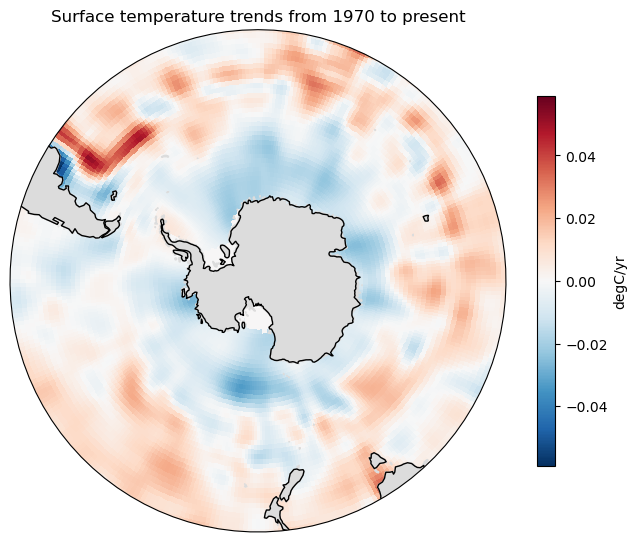

In [11]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())
ax = stereographic_axis(ax)
surface_temp_trends['trend'].plot(ax = ax, transform = ccrs.PlateCarree(),
                                  cbar_kwargs = {'label': 'degC/yr', 'shrink':.6})
plt.title('Surface temperature trends from 1970 to present');

This is very similar to the map we'd done in `1_Introduction_to_EN422.ipynb` with the difference in temperatures between the last decade and the first decade of the observations. This is probably because when we did the "anomaly" map we selected a long enough period (1 decade) which is a good representation of the initial and final states of temperature in our dataset. 

If we had selected just one year for the anomaly plot, we would have run the risk of having selected a year that is not representative of the overall decade. There would be interannual variability in our surface temperatures that make some years hotter than usual, or cooler than usual. The decadal average smoothes that out. 

In any case, trends are a more robust way of analysing changes. There is something else missing in our map, which is the statistical significance of our trends. Not every trend in our map will be significant! A usual way of showing significance is to "hatch", or cross-out, the areas where the trends are *not significant*. Remember that this is where our `signif` variable has 0s.

To add the hatching, we will need to replace by `NaN` every value that is not zero in our `signif` variable. We can do this by using the `xarray.where()` function. We need to give this function a condition, whihc in our case is `surface_temp_trends['signif'] == 0`. Then we need to tell it what to put in the locations where that condition is satisfied (we will put 1s), and what to put where it is not satisfied (we will put `NaN`s. The double `==` is used when we want to verify whether a condition is true or not, (a single `=` is used to define stuff). 

So for example, thisis defining A as 1
```
A = 1
```
and this is asking whether A is equal to 2
```
A == 2
```
which will return a `False`:

In [22]:
A = 1
A == 2

False

In [19]:
non_significant_trends = xr.where(surface_temp_trends['signif'] == 0, 1, np.nan)

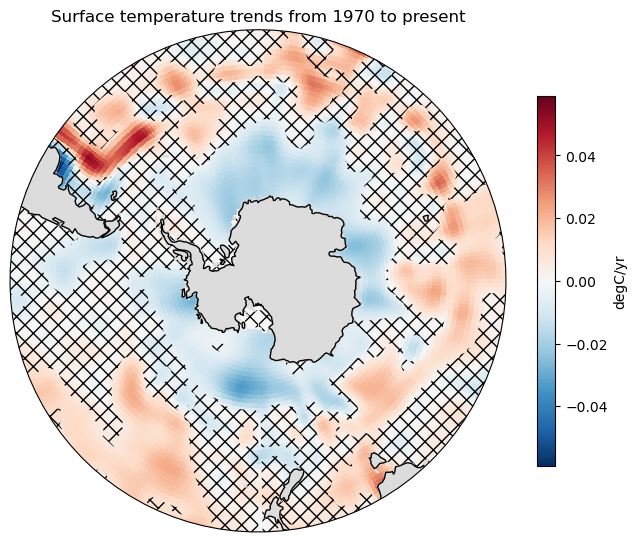

In [21]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())
ax = stereographic_axis(ax)
surface_temp_trends['trend'].plot(ax = ax, transform = ccrs.PlateCarree(),
                                  cbar_kwargs = {'label': 'degC/yr', 'shrink':.6})
# Add hatching
non_significant_trends.plot.contourf(ax = ax, transform = ccrs.PlateCarree(), 
                                     add_colorbar = False, colors = ['none'], hatches = ['xx'])
plt.title('Surface temperature trends from 1970 to present');

#### Question 1

There is significant cooling of the temperatures at the surface in the Southern Ocean around the Antarctic continental margin. Does this surprise you? Do you have any ideas as to what might be happening?

Compute surface salinity trends as well to complement your discussion.

*Answer here*

# Bottom properties trends

<div style="float: right; margin-right: 20px; margin-left: 30px; width: 15%;">
    <img src="images/bottom_selection.png" width="100%"/>
</div>

We have taken a look at what's happening at the surface of the ocean. What about the bottom? 

Getting bottom properties is a bit more tricky than selecting the surface. Remember that to select surface temperatures, we had used `.sel(depth = 0, method = 'nearest')` to grab the depth level closest to zero. We can't replace zero by the "bottom" value, because the bottom is at different depths! 

And what about using `.isel(depth = -1)` to select the last depth in our array? That would be grabbing the red points in the schematic on the right, which are indeed the last depth of our array but because they are beneath the bottom don't have any values attached. What we want are the green points! W actually need to select is the *last level at which we have temperature information*. And we have to do a bit of a workaround for this. 

But let's do a rapid test of `.isel(depth = -1)` just to verify what we're saying is correct.

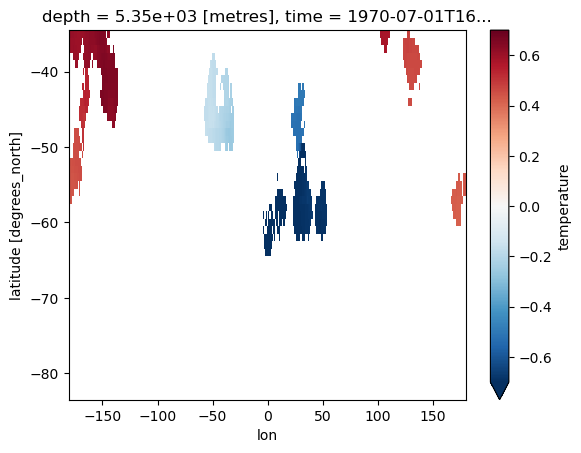

In [16]:
EN422['temperature'].isel(depth = -1, time = 0).plot(vmin = -.7, vmax = .7, cmap = 'RdBu_r');

A way of selecting the bottom values is:
1. Create a mask that has 1s where we have temperature data, and 0s over land.
2. Do a cumulative sum from the surface down, which will reach a maximum value once we get to the bottom and start adding 0s.
3. Select the location of the maxium of the cumulative sum
4. Evaluate our temperatures at the location of the maximum

Voila! Now we have bottom temperatures.

To create the mask we are going to use `xr.where()` again. This time we use `np.isnan()`. Our `.where()` function is basically asking that "where my array has nans I want zeros, otherwise I want ones".

In [27]:
mask = xr.where(np.isnan(EN422['temperature']), 0, 1)

Do a cumulative sum along the depth dimension:

In [28]:
mask = mask.cumsum('depth')

Retrieve the location of the maximum with `.argmax()`. Don't use `.max()`! That will just return the value of the maximum, we want the location, which is where the bottom will be:

In [29]:
bottom_level = mask.argmax('depth')

Now retrieve the temperatures at the bottom locations:

In [30]:
bottom_temperature = EN422['temperature'].isel(depth = bottom_level)

Let's verify it looks correct:

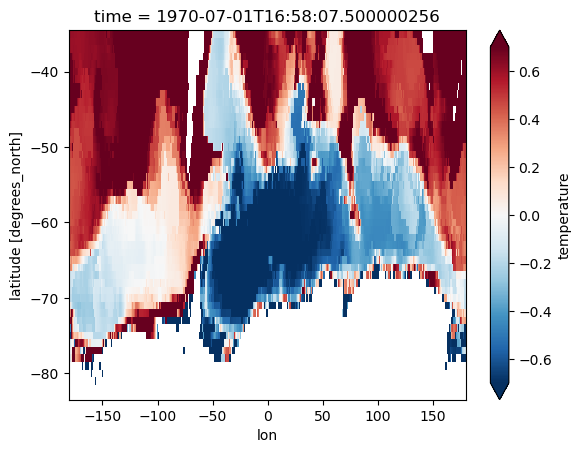

In [31]:
bottom_temperature.isel(time = 0).plot(vmin = -.7, vmax = .7, cmap = 'RdBu_r');

Great! We have selected the temperatures at the bottom correctly. 

#### Question 2

Look at the Antarctic margins. They look very patchy! Why do you think that is?

*Answer here*

Now that we have our bottom temperatures, we are ready to calculate the trends:

In [32]:
MK_class = xrmk.Mann_Kendall_test(bottom_temperature, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
bottom_temperature_trends = MK_class.compute()
bottom_temperature_trends = bottom_temperature_trends.rename({'x':'lon', 'y':'lat'})

Create the array for the significance hatching:

In [34]:
non_significant_trends = xr.where(bottom_temperature_trends['signif'] == 0, 1, np.nan)

And now plot them:

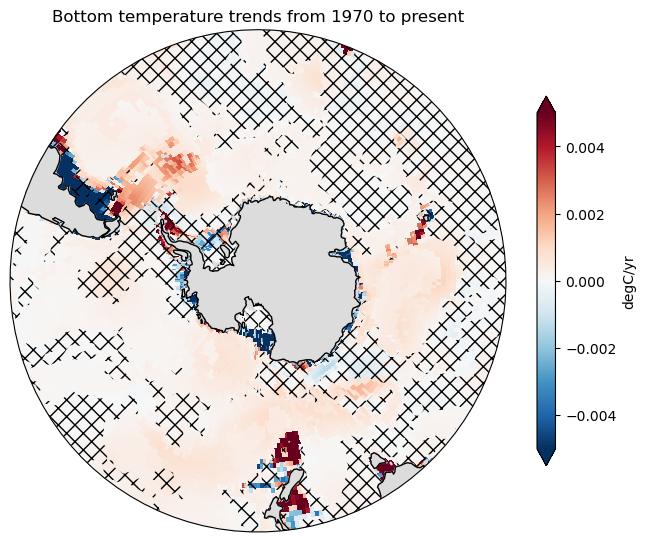

In [35]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())
ax = stereographic_axis(ax)
bottom_temperature_trends['trend'].plot(ax = ax, transform = ccrs.PlateCarree(), vmin = -.005, vmax = .005, cmap = 'RdBu_r',
                                        cbar_kwargs = {'label': 'degC/yr', 'shrink':.6})
non_significant_trends.plot.contourf(ax = ax, transform = ccrs.PlateCarree(), 
                                     add_colorbar = False, colors = ['none'], hatches = ['xx'])
plt.title('Bottom temperature trends from 1970 to present');

Note how the magnitude of the changes is a couple of times smaller than the changes at the surface. This is to be expected, because the rate at which the abyssal ocean communicates with the surface, through where "information" about global warming is coming, is really really small. Changes in the bottom of the ocean are slow to come and spread, but are nevertheless a symptom of climate change. 

Take a look at the paper of [Purkey and Johnson (2010)](https://journals.ametsoc.org/view/journals/clim/23/23/2010jcli3682.1.xml), or the more recent [Li et al. (2023)](https://www.nature.com/articles/s41586-023-05762-w) and compare how similar are the trends at the bottom we have calculated with their results. 

#### Question 3

Calculate bottom salinity trends and discuss the results. 


*Tip: you can use the same `bottom_level` we used for temperature.*

*Answer here*

# Zonal average trends

We have looked at the surface and bottom properties trends. Now let's look at the trends at different levels in the water column by calculating the trends of a zonal average. 

In [36]:
zonal_avg_temperature = EN422['temperature'].mean('lon')

Now whe we calculate the trends, there is a subtle difference: our `x` dimension will be latitude, and `y` will be depth. We no longer have a longitude dimension!

In [37]:
MK_class = xrmk.Mann_Kendall_test(zonal_avg_temperature, 'time', coords_name = {'time':'time', 'depth':'y', 'lat':'x'})
zonal_avg_temperature_trends = MK_class.compute()
# The results are given with x, y dimensions. Let's rename them back to lat, lon
zonal_avg_temperature_trends = zonal_avg_temperature_trends.rename({'x':'lat', 'y':'depth'})

In [38]:
non_significant_trends = xr.where(zonal_avg_temperature_trends['signif'] == 0, 1, np.nan)

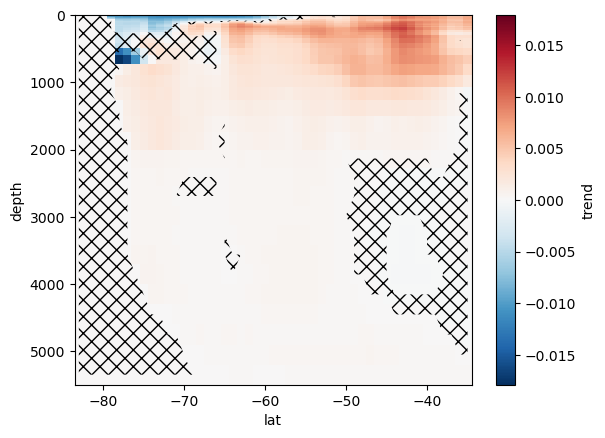

In [39]:
zonal_avg_temperature_trends['trend'].plot(cmap = 'RdBu_r');
non_significant_trends.plot.contourf(add_colorbar = False, colors = ['none'], hatches = ['xx'])
plt.gca().invert_yaxis()

Doesn't look quite nice! The bottom mask has dissappeared when we used the `xrmk.Mann_Kendall_test()` function. Let's mask our `zonal_avg_temperature_trends` and put `NaN`s in land.

In [40]:
zonal_avg_temperature_trends = xr.where(np.isnan(zonal_avg_temperature.isel(time = 0)), np.nan, zonal_avg_temperature_trends)

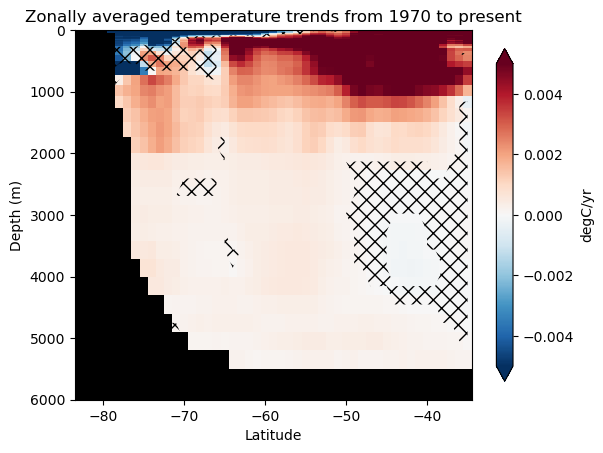

In [41]:
zonal_avg_temperature_trends['trend'].plot(cmap = 'RdBu_r', vmin = -.005, vmax = .005, cbar_kwargs = {'label': 'degC/yr', 'shrink':.9});
non_significant_trends.plot.contourf(add_colorbar = False, colors = ['none'], hatches = ['xx'])

plt.gca().invert_yaxis()
plt.ylim(6000, None)
plt.xlabel('Latitude')
plt.ylabel('Depth (m)');   
plt.gca().set_facecolor('k');
plt.title('Zonally averaged temperature trends from 1970 to present');

There is a large subsurface warming happening in the Southern Ocean, which is the [warming of the Circumpolar Deep Water layer](https://www.science.org/doi/full/10.1126/science.1256117). 

#### Question 4

Repeat the analysis for salinity and discuss the observed trends.

*Answer here*